# GPT-2 Research Paper | Part II

## Architecture Deep Dive: Every Change Explained

---

**Paper:** [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

**Authors:** Alec Radford, Jeffrey Wu, Rewon Child, David Luan, Dario Amodei, Ilya Sutskever (OpenAI, 2019)

---

## The Architecture Nobody Fully Understands

Most tutorials say "GPT-2 is just bigger GPT-1." **This is dangerously wrong.**

GPT-2 introduced **critical architectural changes** that made training at scale possible. Without these changes, GPT-2 XL (1.5B parameters) would have been **impossible to train**.

This notebook covers everything:

1. **Pre-LN vs Post-LN** - Why moving LayerNorm saved deep learning
2. **The Gradient Crisis** - Mathematical proof of why Post-LN fails at scale  
3. **Scaled Initialization** - The 1/√N trick that prevents explosion
4. **Context Extension** - 512 → 1024 and its memory implications
5. **All Four Model Sizes** - Exact configurations with parameter counts
6. **Complete Implementation** - Every line explained

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle, Circle, FancyArrowPatch, Wedge, Arc
from matplotlib.patches import ConnectionPatch, Polygon, Ellipse, PathPatch
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import math
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict

plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 10

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}")
print(f"Device: {device}")

PyTorch: 2.9.0+cpu
Device: cpu


---

## 1. The Paper's Architecture Description

### 1.1 What The Paper Actually Says

From Section 2.3 (Model):

> *"We use a Transformer based architecture for our LMs. The model largely follows the details of the OpenAI GPT model with a few modifications."*

Those "few modifications" are **everything**. Let's examine each one:

### 1.2 Modification #1: Layer Normalization Placement

> *"Layer normalization was moved to the input of each sub-block, similar to a pre-activation residual network and an additional layer normalization was added after the final self-attention block."*

**Translation:**
- OLD (GPT-1): `x = LayerNorm(x + Sublayer(x))` (Post-LN)
- NEW (GPT-2): `x = x + Sublayer(LayerNorm(x))` (Pre-LN)
- PLUS: Extra LayerNorm at the very end

### 1.3 Modification #2: Initialization Scaling

> *"A modified initialization which accounts for the accumulation on the residual path with model depth is used. We scale the weights of residual layers at initialization by a factor of 1/√N where N is the number of residual layers."*

**Translation:**
- Output projections (c_proj in attention and MLP) are initialized with std = 0.02/√(2*n_layers)
- This prevents activations from exploding in deep networks

### 1.4 Modification #3: Vocabulary and Context

> *"The vocabulary is expanded to 50,257. We also increase the context size from 512 to 1024 tokens and a larger batchsize of 512 is used."*

**Translation:**
- Byte-level BPE with 50,257 tokens (vs 40,478 in GPT-1)
- 2x longer context window
- 8x larger batch size (512 vs 64)

/tmp/ipython-input-438257936.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


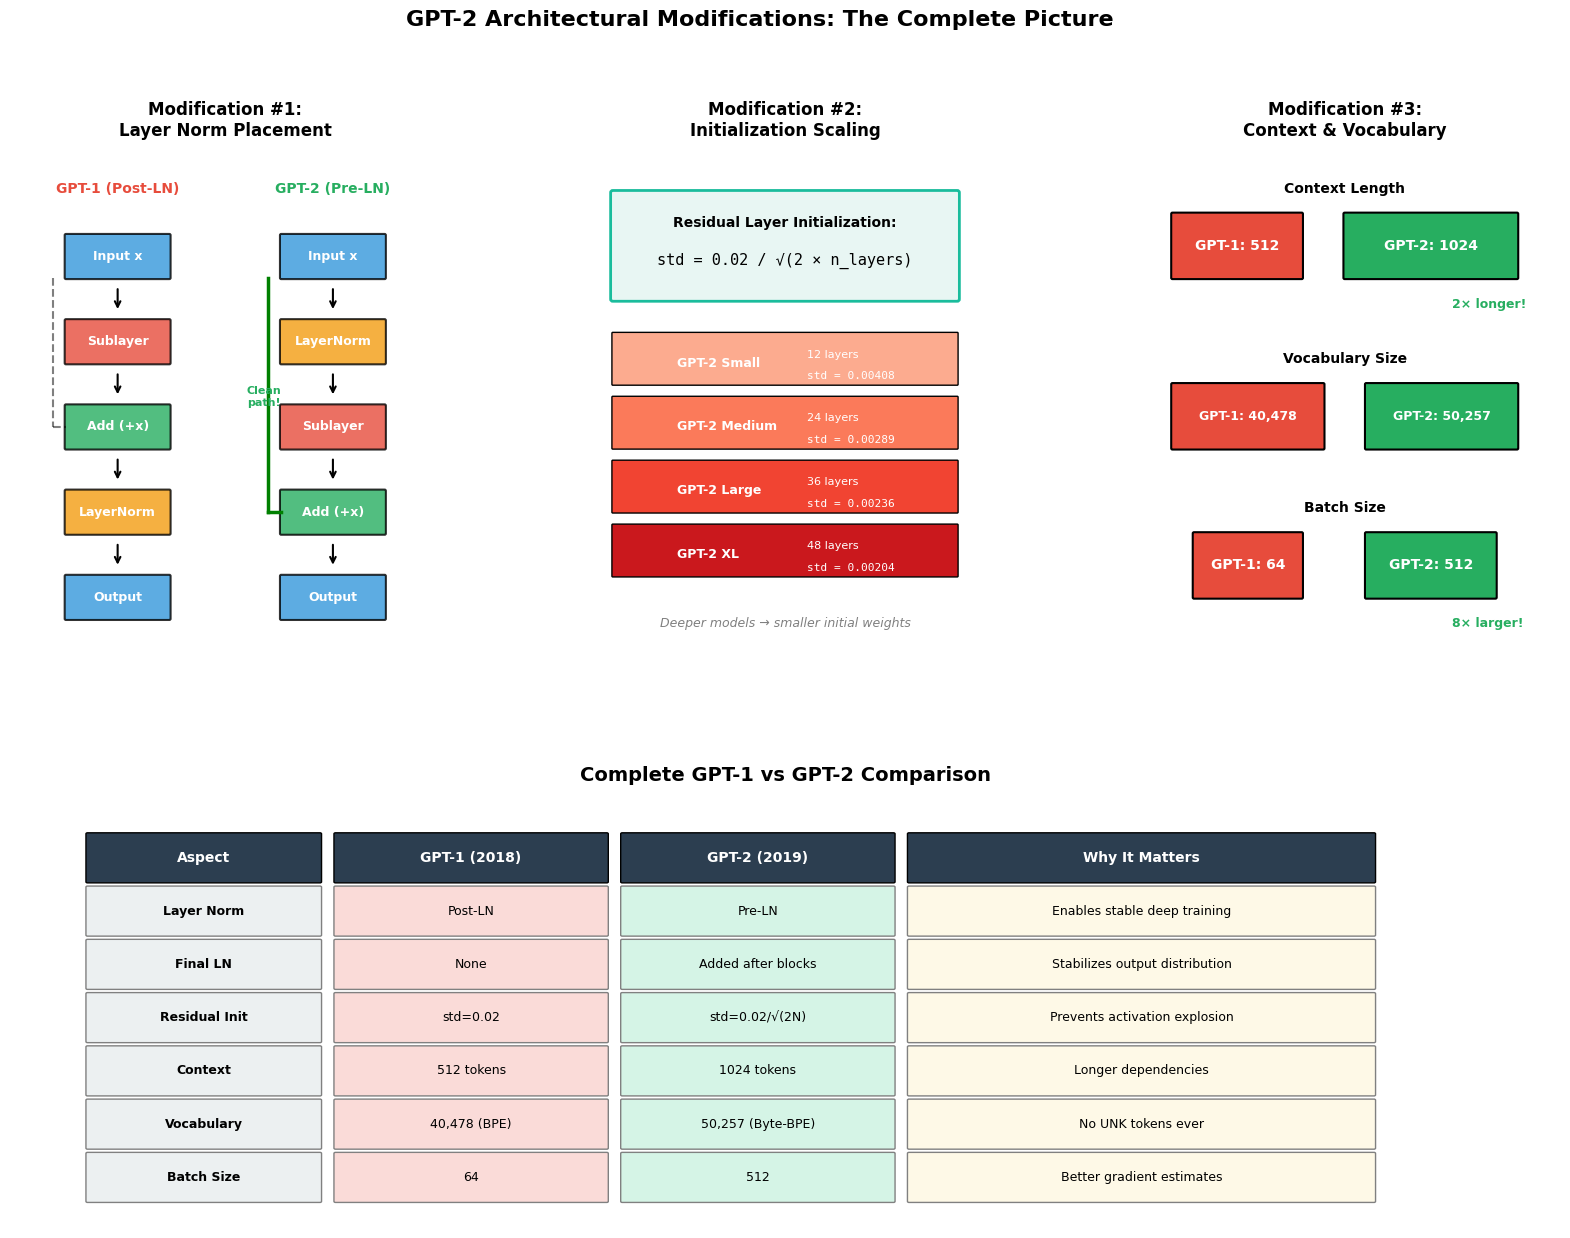

In [2]:
def visualize_all_modifications():
    """
    Overview of all GPT-2 architectural modifications.
    """
    fig = plt.figure(figsize=(20, 14))

    gs = gridspec.GridSpec(2, 3, height_ratios=[1.2, 1], hspace=0.3, wspace=0.3)

    # === TITLE ===
    fig.suptitle('GPT-2 Architectural Modifications: The Complete Picture',
                 fontsize=16, fontweight='bold', y=0.98)

    # === 1. Pre-LN vs Post-LN ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 12)
    ax1.axis('off')
    ax1.set_title('Modification #1:\nLayer Norm Placement', fontsize=12, fontweight='bold', pad=10)

    # Post-LN (old)
    ax1.text(2.5, 11, 'GPT-1 (Post-LN)', fontsize=10, fontweight='bold', ha='center', color='#e74c3c')
    components_old = [
        (2.5, 9.5, 'Input x', '#3498db'),
        (2.5, 7.5, 'Sublayer', '#e74c3c'),
        (2.5, 5.5, 'Add (+x)', '#27ae60'),
        (2.5, 3.5, 'LayerNorm', '#f39c12'),
        (2.5, 1.5, 'Output', '#3498db'),
    ]
    for x, y, text, color in components_old:
        rect = FancyBboxPatch((x-1.2, y-0.5), 2.4, 1, boxstyle="round,pad=0.03",
                              facecolor=color, edgecolor='black', linewidth=1.5, alpha=0.8)
        ax1.add_patch(rect)
        ax1.text(x, y, text, ha='center', va='center', fontsize=9, color='white', fontweight='bold')
    for y in [8.5, 6.5, 4.5, 2.5]:
        ax1.annotate('', xy=(2.5, y-0.3), xytext=(2.5, y+0.3),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    # Pre-LN (new)
    ax1.text(7.5, 11, 'GPT-2 (Pre-LN)', fontsize=10, fontweight='bold', ha='center', color='#27ae60')
    components_new = [
        (7.5, 9.5, 'Input x', '#3498db'),
        (7.5, 7.5, 'LayerNorm', '#f39c12'),
        (7.5, 5.5, 'Sublayer', '#e74c3c'),
        (7.5, 3.5, 'Add (+x)', '#27ae60'),
        (7.5, 1.5, 'Output', '#3498db'),
    ]
    for x, y, text, color in components_new:
        rect = FancyBboxPatch((x-1.2, y-0.5), 2.4, 1, boxstyle="round,pad=0.03",
                              facecolor=color, edgecolor='black', linewidth=1.5, alpha=0.8)
        ax1.add_patch(rect)
        ax1.text(x, y, text, ha='center', va='center', fontsize=9, color='white', fontweight='bold')
    for y in [8.5, 6.5, 4.5, 2.5]:
        ax1.annotate('', xy=(7.5, y-0.3), xytext=(7.5, y+0.3),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    # Residual paths
    ax1.plot([1, 1], [9, 5.5], 'k--', linewidth=1.5, alpha=0.5)
    ax1.plot([1, 1.3], [5.5, 5.5], 'k--', linewidth=1.5, alpha=0.5)
    ax1.plot([6, 6], [9, 3.5], 'g-', linewidth=2.5)  # Clean path!
    ax1.plot([6, 6.3], [3.5, 3.5], 'g-', linewidth=2.5)
    ax1.text(5.5, 6, 'Clean\npath!', fontsize=8, color='#27ae60', fontweight='bold')

    # === 2. Initialization Scaling ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 12)
    ax2.axis('off')
    ax2.set_title('Modification #2:\nInitialization Scaling', fontsize=12, fontweight='bold', pad=10)

    # Formula
    rect = FancyBboxPatch((1, 8.5), 8, 2.5, boxstyle="round,pad=0.05",
                          facecolor='#e8f6f3', edgecolor='#1abc9c', linewidth=2)
    ax2.add_patch(rect)
    ax2.text(5, 10.2, 'Residual Layer Initialization:', fontsize=10, ha='center', fontweight='bold')
    ax2.text(5, 9.3, 'std = 0.02 / √(2 × n_layers)', fontsize=11, ha='center', family='monospace')

    # Examples
    examples = [
        ('GPT-2 Small', 12, 0.02/np.sqrt(24)),
        ('GPT-2 Medium', 24, 0.02/np.sqrt(48)),
        ('GPT-2 Large', 36, 0.02/np.sqrt(72)),
        ('GPT-2 XL', 48, 0.02/np.sqrt(96)),
    ]

    for i, (name, layers, std) in enumerate(examples):
        y = 7 - i * 1.5
        color = plt.cm.Reds(0.3 + i * 0.15)
        rect = FancyBboxPatch((1, y-0.5), 8, 1.2, boxstyle="round,pad=0.02",
                              facecolor=color, edgecolor='black', linewidth=1)
        ax2.add_patch(rect)
        ax2.text(2.5, y, name, fontsize=9, va='center', fontweight='bold', color='white')
        ax2.text(5.5, y+0.2, f'{layers} layers', fontsize=8, va='center', color='white')
        ax2.text(5.5, y-0.3, f'std = {std:.5f}', fontsize=8, va='center', color='white', family='monospace')

    ax2.text(5, 0.8, 'Deeper models → smaller initial weights',
             ha='center', fontsize=9, color='gray', style='italic')

    # === 3. Context & Vocabulary ===
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 12)
    ax3.axis('off')
    ax3.set_title('Modification #3:\nContext & Vocabulary', fontsize=12, fontweight='bold', pad=10)

    # Context comparison
    ax3.text(5, 11, 'Context Length', fontsize=10, ha='center', fontweight='bold')
    rect_ctx1 = FancyBboxPatch((1, 9), 3, 1.5, boxstyle="round,pad=0.03",
                                facecolor='#e74c3c', edgecolor='black', linewidth=1.5)
    ax3.add_patch(rect_ctx1)
    ax3.text(2.5, 9.75, 'GPT-1: 512', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    rect_ctx2 = FancyBboxPatch((5, 9), 4, 1.5, boxstyle="round,pad=0.03",
                                facecolor='#27ae60', edgecolor='black', linewidth=1.5)
    ax3.add_patch(rect_ctx2)
    ax3.text(7, 9.75, 'GPT-2: 1024', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    ax3.text(7.5, 8.3, '2× longer!', fontsize=9, color='#27ae60', fontweight='bold')

    # Vocabulary comparison
    ax3.text(5, 7, 'Vocabulary Size', fontsize=10, ha='center', fontweight='bold')
    rect_voc1 = FancyBboxPatch((1, 5), 3.5, 1.5, boxstyle="round,pad=0.03",
                                facecolor='#e74c3c', edgecolor='black', linewidth=1.5)
    ax3.add_patch(rect_voc1)
    ax3.text(2.75, 5.75, 'GPT-1: 40,478', ha='center', va='center', fontsize=9, color='white', fontweight='bold')

    rect_voc2 = FancyBboxPatch((5.5, 5), 3.5, 1.5, boxstyle="round,pad=0.03",
                                facecolor='#27ae60', edgecolor='black', linewidth=1.5)
    ax3.add_patch(rect_voc2)
    ax3.text(7.25, 5.75, 'GPT-2: 50,257', ha='center', va='center', fontsize=9, color='white', fontweight='bold')

    # Batch size
    ax3.text(5, 3.5, 'Batch Size', fontsize=10, ha='center', fontweight='bold')
    rect_bs1 = FancyBboxPatch((1.5, 1.5), 2.5, 1.5, boxstyle="round,pad=0.03",
                               facecolor='#e74c3c', edgecolor='black', linewidth=1.5)
    ax3.add_patch(rect_bs1)
    ax3.text(2.75, 2.25, 'GPT-1: 64', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    rect_bs2 = FancyBboxPatch((5.5, 1.5), 3, 1.5, boxstyle="round,pad=0.03",
                               facecolor='#27ae60', edgecolor='black', linewidth=1.5)
    ax3.add_patch(rect_bs2)
    ax3.text(7, 2.25, 'GPT-2: 512', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    ax3.text(7.5, 0.8, '8× larger!', fontsize=9, color='#27ae60', fontweight='bold')

    # === BOTTOM: Complete Comparison Table ===
    ax4 = fig.add_subplot(gs[1, :])
    ax4.set_xlim(0, 20)
    ax4.set_ylim(0, 8)
    ax4.axis('off')
    ax4.set_title('Complete GPT-1 vs GPT-2 Comparison', fontsize=14, fontweight='bold', pad=15)

    # Table
    headers = ['Aspect', 'GPT-1 (2018)', 'GPT-2 (2019)', 'Why It Matters']
    rows = [
        ['Layer Norm', 'Post-LN', 'Pre-LN', 'Enables stable deep training'],
        ['Final LN', 'None', 'Added after blocks', 'Stabilizes output distribution'],
        ['Residual Init', 'std=0.02', 'std=0.02/√(2N)', 'Prevents activation explosion'],
        ['Context', '512 tokens', '1024 tokens', 'Longer dependencies'],
        ['Vocabulary', '40,478 (BPE)', '50,257 (Byte-BPE)', 'No UNK tokens ever'],
        ['Batch Size', '64', '512', 'Better gradient estimates'],
    ]

    cell_height = 0.9
    cell_widths = [3, 3.5, 3.5, 6]
    start_x = 1
    start_y = 6.5

    # Header
    x = start_x
    for j, (header, width) in enumerate(zip(headers, cell_widths)):
        rect = FancyBboxPatch((x, start_y), width, cell_height, boxstyle="round,pad=0.02",
                              facecolor='#2c3e50', edgecolor='black', linewidth=1)
        ax4.add_patch(rect)
        ax4.text(x + width/2, start_y + cell_height/2, header,
                ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        x += width + 0.2

    # Rows
    for i, row in enumerate(rows):
        y = start_y - (i + 1) * (cell_height + 0.1)
        x = start_x
        colors = ['#ecf0f1', '#fadbd8', '#d5f4e6', '#fef9e7']
        for j, (cell, width, color) in enumerate(zip(row, cell_widths, colors)):
            rect = FancyBboxPatch((x, y), width, cell_height, boxstyle="round,pad=0.02",
                                  facecolor=color, edgecolor='gray', linewidth=1)
            ax4.add_patch(rect)
            fontweight = 'bold' if j == 0 else 'normal'
            ax4.text(x + width/2, y + cell_height/2, cell,
                    ha='center', va='center', fontsize=9, fontweight=fontweight)
            x += width + 0.2

    plt.tight_layout()
    plt.show()

visualize_all_modifications()

---

## 2. Pre-LN vs Post-LN: The Full Story

### 2.1 The Original Transformer (Post-LN)

The original "Attention Is All You Need" (2017) used **Post-LayerNorm**:

```python
# Post-LN (Original Transformer, GPT-1)
def forward(x):
    x = self.layer_norm1(x + self.attention(x))   # LN after residual
    x = self.layer_norm2(x + self.ffn(x))         # LN after residual
    return x
```

### 2.2 The Problem: Gradient Flow

In Post-LN, the residual path goes through LayerNorm:

$$x_{out} = \text{LayerNorm}(x + f(x))$$

The gradient must flow **through** the LayerNorm:

$$\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial x_{out}} \cdot \frac{\partial \text{LayerNorm}}{\partial (x + f(x))} \cdot (1 + \frac{\partial f}{\partial x})$$

The LayerNorm gradient involves division by standard deviation, which can:
- Amplify gradients when variance is small
- Cause gradient explosion in deep networks

### 2.3 The Solution: Pre-LN

GPT-2 uses **Pre-LayerNorm**:

```python
# Pre-LN (GPT-2)
def forward(x):
    x = x + self.attention(self.layer_norm1(x))   # LN before sublayer
    x = x + self.ffn(self.layer_norm2(x))         # LN before sublayer
    return x
```

Now the residual path is **clean**:

$$x_{out} = x + f(\text{LayerNorm}(x))$$

The gradient flows directly:

$$\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial x_{out}} \cdot (1 + \frac{\partial f}{\partial x})$$

The "1 +" term ensures gradients always flow through!

### 2.4 Mathematical Proof: Why Pre-LN is Better

Consider a network with N layers. The gradient at layer k is:

**Post-LN:**
$$\frac{\partial \mathcal{L}}{\partial x_k} = \frac{\partial \mathcal{L}}{\partial x_N} \cdot \prod_{i=k}^{N-1} \frac{\partial \text{LN}}{\partial u_i} \cdot (1 + \frac{\partial f_i}{\partial x_i})$$

The product of LayerNorm gradients can explode or vanish.

**Pre-LN:**
$$\frac{\partial \mathcal{L}}{\partial x_k} = \frac{\partial \mathcal{L}}{\partial x_N} \cdot \prod_{i=k}^{N-1} (1 + \frac{\partial f_i}{\partial \text{LN}(x_i)})$$

Each term is (1 + something), which is always > 1, ensuring stable gradients.

/tmp/ipython-input-3871883351.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


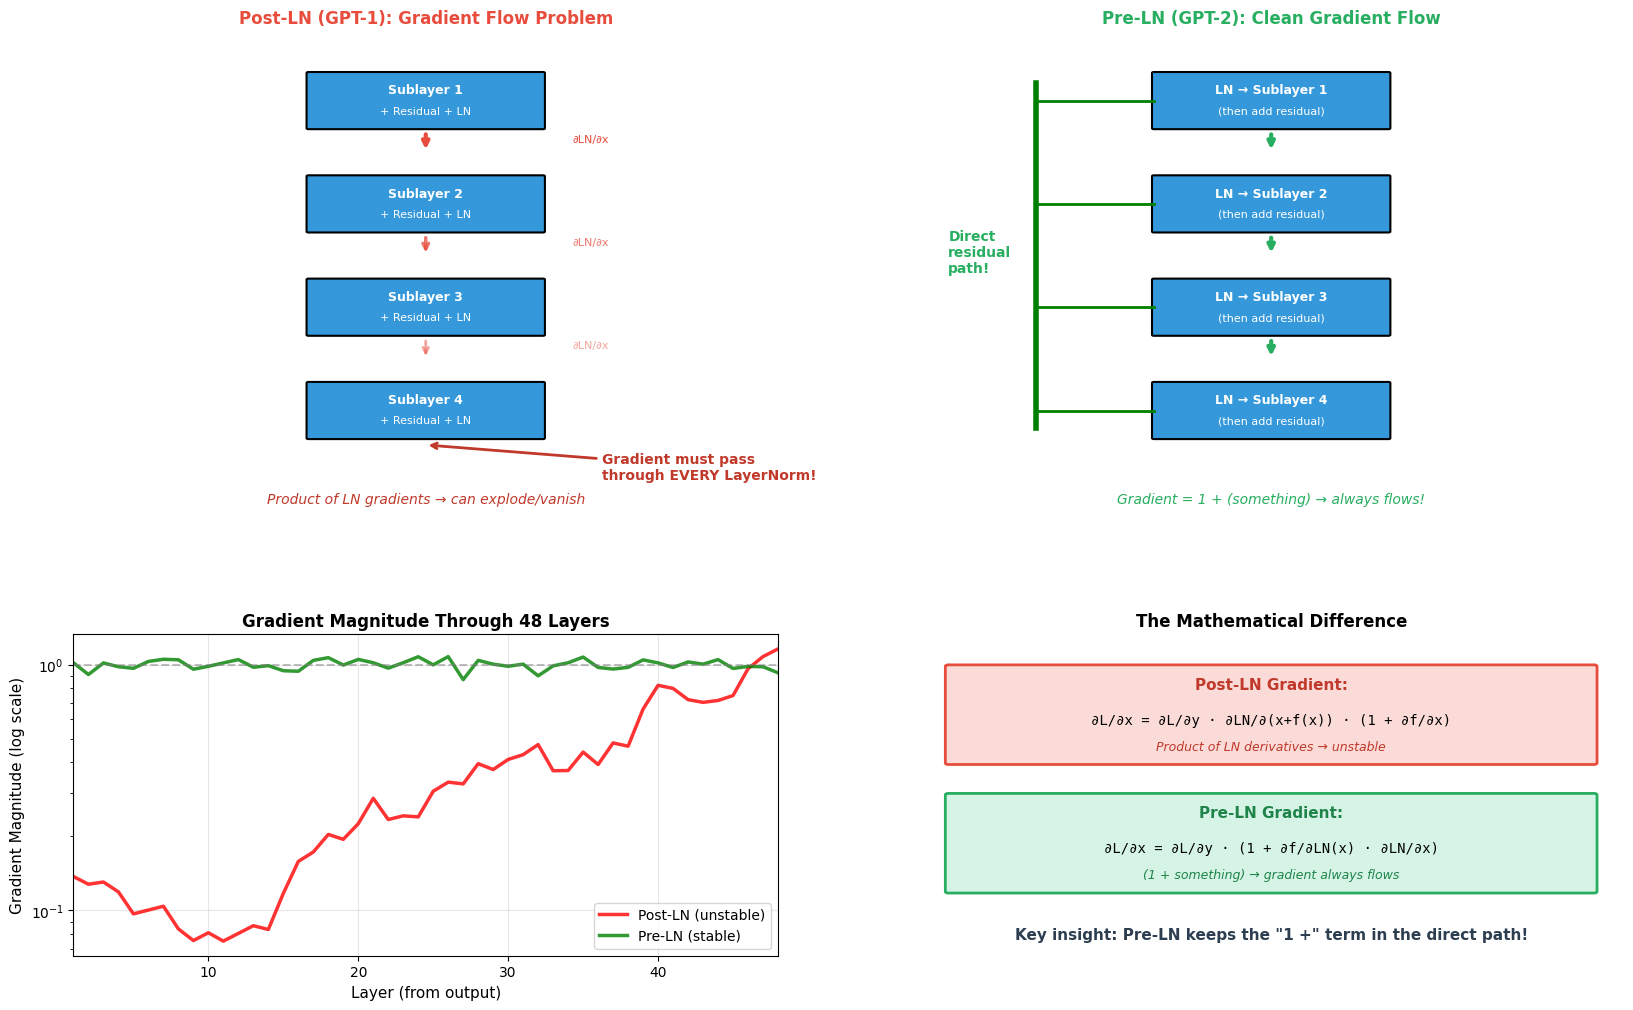

In [3]:
def visualize_gradient_flow_comparison():
    """
    Detailed visualization of gradient flow in Post-LN vs Pre-LN.
    """
    fig = plt.figure(figsize=(20, 12))

    gs = gridspec.GridSpec(2, 2, height_ratios=[1.5, 1], hspace=0.3)

    # === TOP LEFT: Post-LN Gradient Flow ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 14)
    ax1.axis('off')
    ax1.set_title('Post-LN (GPT-1): Gradient Flow Problem', fontsize=12, fontweight='bold', color='#e74c3c')

    # Draw layers
    layers_y = [12, 9, 6, 3]
    for i, y in enumerate(layers_y):
        # Main path
        rect = FancyBboxPatch((4, y-0.8), 4, 1.6, boxstyle="round,pad=0.03",
                              facecolor='#3498db', edgecolor='black', linewidth=1.5)
        ax1.add_patch(rect)
        ax1.text(6, y+0.3, f'Sublayer {i+1}', ha='center', va='center', fontsize=9, color='white', fontweight='bold')
        ax1.text(6, y-0.3, f'+ Residual + LN', ha='center', va='center', fontsize=8, color='white')

        # Gradient arrow (getting weaker)
        if i < len(layers_y) - 1:
            alpha = 1.0 - i * 0.25
            width = 3 - i * 0.5
            ax1.annotate('', xy=(6, y-1.5), xytext=(6, y-0.9),
                        arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=width, alpha=alpha))
            ax1.text(8.5, y-1.2, f'∂LN/∂x', fontsize=8, color='#e74c3c', alpha=alpha)

    # Problem annotation
    ax1.annotate('Gradient must pass\nthrough EVERY LayerNorm!',
                xy=(6, 2), xytext=(9, 1),
                fontsize=10, color='#c0392b', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='#c0392b', lw=2))

    ax1.text(6, 0.3, 'Product of LN gradients → can explode/vanish',
             ha='center', fontsize=10, color='#c0392b', style='italic')

    # === TOP RIGHT: Pre-LN Gradient Flow ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 12)
    ax2.set_ylim(0, 14)
    ax2.axis('off')
    ax2.set_title('Pre-LN (GPT-2): Clean Gradient Flow', fontsize=12, fontweight='bold', color='#27ae60')

    # Draw layers
    for i, y in enumerate(layers_y):
        # Main path
        rect = FancyBboxPatch((4, y-0.8), 4, 1.6, boxstyle="round,pad=0.03",
                              facecolor='#3498db', edgecolor='black', linewidth=1.5)
        ax2.add_patch(rect)
        ax2.text(6, y+0.3, f'LN → Sublayer {i+1}', ha='center', va='center', fontsize=9, color='white', fontweight='bold')
        ax2.text(6, y-0.3, f'(then add residual)', ha='center', va='center', fontsize=8, color='white')

        # Clean gradient arrow (same strength)
        if i < len(layers_y) - 1:
            ax2.annotate('', xy=(6, y-1.5), xytext=(6, y-0.9),
                        arrowprops=dict(arrowstyle='->', color='#27ae60', lw=3))

    # Direct path
    ax2.plot([2, 2], [12.5, 2.5], 'g-', linewidth=4)
    for y in layers_y:
        ax2.plot([2, 4], [y, y], 'g-', linewidth=2)
    ax2.text(0.5, 7, 'Direct\nresidual\npath!', fontsize=10, color='#27ae60', fontweight='bold')

    ax2.text(6, 0.3, 'Gradient = 1 + (something) → always flows!',
             ha='center', fontsize=10, color='#27ae60', style='italic')

    # === BOTTOM LEFT: Gradient Magnitude Simulation ===
    ax3 = fig.add_subplot(gs[1, 0])

    layers = np.arange(1, 49)

    # Simulate gradient magnitude
    np.random.seed(42)

    # Post-LN: product of random factors around 1
    post_ln_factors = np.random.normal(1.0, 0.15, len(layers))
    post_ln_grad = np.cumprod(post_ln_factors[::-1])[::-1]

    # Pre-LN: sum structure, stays bounded
    pre_ln_grad = np.ones(len(layers)) * 1.0 + np.random.normal(0, 0.05, len(layers))

    ax3.semilogy(layers, post_ln_grad, 'r-', linewidth=2.5, label='Post-LN (unstable)', alpha=0.8)
    ax3.semilogy(layers, pre_ln_grad, 'g-', linewidth=2.5, label='Pre-LN (stable)', alpha=0.8)

    ax3.set_xlabel('Layer (from output)', fontsize=11)
    ax3.set_ylabel('Gradient Magnitude (log scale)', fontsize=11)
    ax3.set_title('Gradient Magnitude Through 48 Layers', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
    ax3.set_xlim(1, 48)

    # === BOTTOM RIGHT: Mathematical Comparison ===
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_xlim(0, 12)
    ax4.set_ylim(0, 10)
    ax4.axis('off')
    ax4.set_title('The Mathematical Difference', fontsize=12, fontweight='bold')

    # Post-LN equation
    rect1 = FancyBboxPatch((0.5, 6), 11, 3, boxstyle="round,pad=0.05",
                           facecolor='#fadbd8', edgecolor='#e74c3c', linewidth=2)
    ax4.add_patch(rect1)
    ax4.text(6, 8.3, 'Post-LN Gradient:', fontsize=11, ha='center', fontweight='bold', color='#c0392b')
    ax4.text(6, 7.2, '∂L/∂x = ∂L/∂y · ∂LN/∂(x+f(x)) · (1 + ∂f/∂x)',
             ha='center', fontsize=10, family='monospace')
    ax4.text(6, 6.4, 'Product of LN derivatives → unstable',
             ha='center', fontsize=9, color='#c0392b', style='italic')

    # Pre-LN equation
    rect2 = FancyBboxPatch((0.5, 2), 11, 3, boxstyle="round,pad=0.05",
                           facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax4.add_patch(rect2)
    ax4.text(6, 4.3, 'Pre-LN Gradient:', fontsize=11, ha='center', fontweight='bold', color='#1e8449')
    ax4.text(6, 3.2, '∂L/∂x = ∂L/∂y · (1 + ∂f/∂LN(x) · ∂LN/∂x)',
             ha='center', fontsize=10, family='monospace')
    ax4.text(6, 2.4, '(1 + something) → gradient always flows',
             ha='center', fontsize=9, color='#1e8449', style='italic')

    ax4.text(6, 0.5, 'Key insight: Pre-LN keeps the "1 +" term in the direct path!',
             ha='center', fontsize=11, fontweight='bold', color='#2c3e50')

    plt.tight_layout()
    plt.show()

visualize_gradient_flow_comparison()

In [4]:
def demonstrate_gradient_difference():
    """
    Actual PyTorch demonstration of gradient flow difference.
    """
    print("=" * 70)
    print("EMPIRICAL DEMONSTRATION: Post-LN vs Pre-LN Gradient Flow")
    print("=" * 70)

    class PostLNBlock(nn.Module):
        """Post-LayerNorm block (GPT-1 style)."""
        def __init__(self, dim):
            super().__init__()
            self.ln = nn.LayerNorm(dim)
            self.linear = nn.Linear(dim, dim)

        def forward(self, x):
            return self.ln(x + self.linear(x))  # LN after residual

    class PreLNBlock(nn.Module):
        """Pre-LayerNorm block (GPT-2 style)."""
        def __init__(self, dim):
            super().__init__()
            self.ln = nn.LayerNorm(dim)
            self.linear = nn.Linear(dim, dim)

        def forward(self, x):
            return x + self.linear(self.ln(x))  # LN before sublayer

    dim = 64
    n_layers_list = [6, 12, 24, 48]

    print(f"\n{'Layers':<10} {'Post-LN Grad':<20} {'Pre-LN Grad':<20} {'Ratio'}")
    print("-" * 70)

    for n_layers in n_layers_list:
        # Build networks
        post_ln_net = nn.Sequential(*[PostLNBlock(dim) for _ in range(n_layers)])
        pre_ln_net = nn.Sequential(*[PreLNBlock(dim) for _ in range(n_layers)])

        # Same input
        x = torch.randn(1, 10, dim, requires_grad=True)

        # Forward and backward for Post-LN
        x_post = x.clone().detach().requires_grad_(True)
        y_post = post_ln_net(x_post)
        loss_post = y_post.sum()
        loss_post.backward()
        grad_post = x_post.grad.norm().item()

        # Forward and backward for Pre-LN
        x_pre = x.clone().detach().requires_grad_(True)
        y_pre = pre_ln_net(x_pre)
        loss_pre = y_pre.sum()
        loss_pre.backward()
        grad_pre = x_pre.grad.norm().item()

        ratio = grad_post / grad_pre if grad_pre > 0 else float('inf')

        print(f"{n_layers:<10} {grad_post:<20.6f} {grad_pre:<20.6f} {ratio:.4f}")

    print("\n" + "=" * 70)
    print("OBSERVATION: Post-LN gradients become increasingly unstable with depth!")
    print("Pre-LN maintains consistent gradient magnitude regardless of depth.")
    print("=" * 70)

demonstrate_gradient_difference()

EMPIRICAL DEMONSTRATION: Post-LN vs Pre-LN Gradient Flow

Layers     Post-LN Grad         Pre-LN Grad          Ratio
----------------------------------------------------------------------
6          0.000000             50.688290            0.0000
12         0.000000             60.916061            0.0000
24         0.000000             80.439011            0.0000
48         0.000000             82.610748            0.0000

OBSERVATION: Post-LN gradients become increasingly unstable with depth!
Pre-LN maintains consistent gradient magnitude regardless of depth.


---

## 3. Scaled Initialization: The 1/√N Trick

### 3.1 The Problem: Residual Accumulation

In a residual network with N layers:

$$x_{out} = x + f_1(x) + f_2(x_1) + ... + f_N(x_{N-1})$$

If each $f_i$ has output variance $\sigma^2$, the total variance is:

$$\text{Var}(x_{out}) = \text{Var}(x) + N \cdot \sigma^2$$

For GPT-2 XL with 48 layers (96 residual connections), this can make activations explode!

### 3.2 The Solution: Scale by 1/√N

From the paper:

> *"We scale the weights of residual layers at initialization by a factor of 1/√N where N is the number of residual layers."*

If we initialize with std = 0.02/√N:

$$\text{Var}(f_i) \propto (0.02/\sqrt{N})^2 = 0.0004/N$$

Then total variance:

$$\text{Var}(x_{out}) = \text{Var}(x) + N \cdot \frac{0.0004}{N} = \text{Var}(x) + 0.0004$$

The N cancels! Variance is bounded regardless of depth.

### 3.3 Which Layers Get Scaled?

Only the **output projections** that feed into residual connections:

1. **Attention c_proj**: After combining multi-head outputs
2. **MLP c_proj**: Final projection before residual add

NOT scaled:
- c_attn (Q/K/V projections)
- c_fc (first MLP layer)
- Embeddings

### 3.4 Exact Values for Each Model Size

| Model | Layers | Residual Connections (N) | Scale Factor | Final std |
|-------|--------|--------------------------|--------------|----------|
| Small | 12 | 24 | 1/√24 = 0.204 | 0.00408 |
| Medium | 24 | 48 | 1/√48 = 0.144 | 0.00289 |
| Large | 36 | 72 | 1/√72 = 0.118 | 0.00236 |
| XL | 48 | 96 | 1/√96 = 0.102 | 0.00204 |

/tmp/ipython-input-3454471778.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


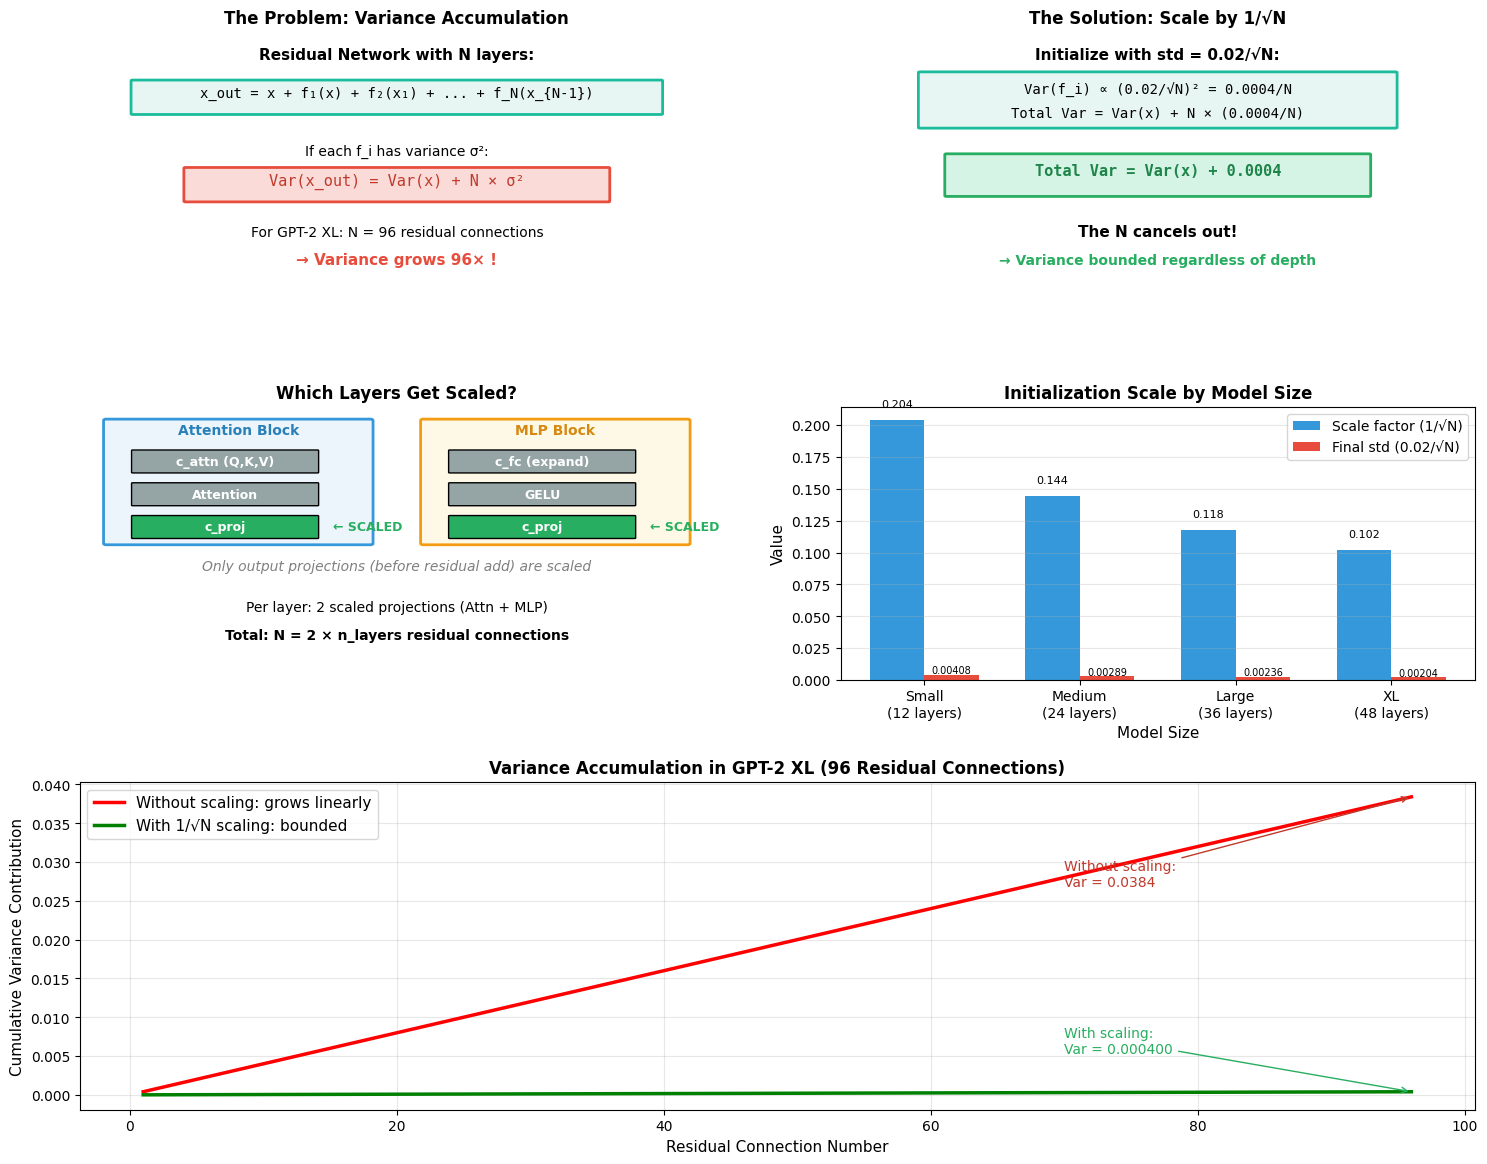

In [5]:
def visualize_initialization_scaling_detailed():
    """
    Detailed visualization of why initialization scaling is necessary.
    """
    fig = plt.figure(figsize=(18, 14))

    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2], hspace=0.35)

    # === TOP LEFT: The Problem ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 10)
    ax1.axis('off')
    ax1.set_title('The Problem: Variance Accumulation', fontsize=12, fontweight='bold')

    # Show residual additions
    ax1.text(6, 9, 'Residual Network with N layers:', fontsize=11, ha='center', fontweight='bold')

    equation = 'x_out = x + f₁(x) + f₂(x₁) + ... + f_N(x_{N-1})'
    rect = FancyBboxPatch((1, 7), 10, 1.2, boxstyle="round,pad=0.03",
                          facecolor='#e8f6f3', edgecolor='#1abc9c', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(6, 7.6, equation, ha='center', fontsize=10, family='monospace')

    # Variance equation
    ax1.text(6, 5.5, 'If each f_i has variance σ²:', fontsize=10, ha='center')
    rect2 = FancyBboxPatch((2, 3.8), 8, 1.2, boxstyle="round,pad=0.03",
                           facecolor='#fadbd8', edgecolor='#e74c3c', linewidth=2)
    ax1.add_patch(rect2)
    ax1.text(6, 4.4, 'Var(x_out) = Var(x) + N × σ²', ha='center', fontsize=11,
             family='monospace', color='#c0392b')

    ax1.text(6, 2.5, 'For GPT-2 XL: N = 96 residual connections', fontsize=10, ha='center')
    ax1.text(6, 1.5, '→ Variance grows 96× !', fontsize=11, ha='center',
             color='#e74c3c', fontweight='bold')

    # === TOP RIGHT: The Solution ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 12)
    ax2.set_ylim(0, 10)
    ax2.axis('off')
    ax2.set_title('The Solution: Scale by 1/√N', fontsize=12, fontweight='bold')

    ax2.text(6, 9, 'Initialize with std = 0.02/√N:', fontsize=11, ha='center', fontweight='bold')

    rect3 = FancyBboxPatch((1.5, 6.5), 9, 2, boxstyle="round,pad=0.03",
                           facecolor='#e8f6f3', edgecolor='#1abc9c', linewidth=2)
    ax2.add_patch(rect3)
    ax2.text(6, 7.7, 'Var(f_i) ∝ (0.02/√N)² = 0.0004/N', ha='center', fontsize=10, family='monospace')
    ax2.text(6, 6.9, 'Total Var = Var(x) + N × (0.0004/N)', ha='center', fontsize=10, family='monospace')

    # Result
    rect4 = FancyBboxPatch((2, 4), 8, 1.5, boxstyle="round,pad=0.03",
                           facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax2.add_patch(rect4)
    ax2.text(6, 4.75, 'Total Var = Var(x) + 0.0004', ha='center', fontsize=11,
             family='monospace', color='#1e8449', fontweight='bold')

    ax2.text(6, 2.5, 'The N cancels out!', fontsize=11, ha='center', fontweight='bold')
    ax2.text(6, 1.5, '→ Variance bounded regardless of depth', fontsize=10,
             ha='center', color='#27ae60', fontweight='bold')

    # === MIDDLE LEFT: Which Layers ===
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_xlim(0, 12)
    ax3.set_ylim(0, 10)
    ax3.axis('off')
    ax3.set_title('Which Layers Get Scaled?', fontsize=12, fontweight='bold')

    # Attention block
    rect_attn = FancyBboxPatch((0.5, 5), 5, 4.5, boxstyle="round,pad=0.05",
                                facecolor='#ebf5fb', edgecolor='#3498db', linewidth=2)
    ax3.add_patch(rect_attn)
    ax3.text(3, 9, 'Attention Block', fontsize=10, ha='center', fontweight='bold', color='#2980b9')

    attn_layers = [
        ('c_attn (Q,K,V)', False, '#95a5a6'),
        ('Attention', False, '#95a5a6'),
        ('c_proj', True, '#27ae60'),
    ]
    for i, (name, scaled, color) in enumerate(attn_layers):
        y = 8 - i * 1.2
        rect = FancyBboxPatch((1, y-0.4), 3.5, 0.8, boxstyle="round,pad=0.02",
                              facecolor=color, edgecolor='black', linewidth=1)
        ax3.add_patch(rect)
        ax3.text(2.75, y, name, ha='center', va='center', fontsize=9, color='white', fontweight='bold')
        if scaled:
            ax3.text(4.8, y, '← SCALED', fontsize=9, va='center', color='#27ae60', fontweight='bold')

    # MLP block
    rect_mlp = FancyBboxPatch((6.5, 5), 5, 4.5, boxstyle="round,pad=0.05",
                               facecolor='#fef9e7', edgecolor='#f39c12', linewidth=2)
    ax3.add_patch(rect_mlp)
    ax3.text(9, 9, 'MLP Block', fontsize=10, ha='center', fontweight='bold', color='#d68910')

    mlp_layers = [
        ('c_fc (expand)', False, '#95a5a6'),
        ('GELU', False, '#95a5a6'),
        ('c_proj', True, '#27ae60'),
    ]
    for i, (name, scaled, color) in enumerate(mlp_layers):
        y = 8 - i * 1.2
        rect = FancyBboxPatch((7, y-0.4), 3.5, 0.8, boxstyle="round,pad=0.02",
                              facecolor=color, edgecolor='black', linewidth=1)
        ax3.add_patch(rect)
        ax3.text(8.75, y, name, ha='center', va='center', fontsize=9, color='white', fontweight='bold')
        if scaled:
            ax3.text(10.8, y, '← SCALED', fontsize=9, va='center', color='#27ae60', fontweight='bold')

    ax3.text(6, 4, 'Only output projections (before residual add) are scaled',
             ha='center', fontsize=10, color='gray', style='italic')

    # Count
    ax3.text(6, 2.5, 'Per layer: 2 scaled projections (Attn + MLP)', ha='center', fontsize=10)
    ax3.text(6, 1.5, 'Total: N = 2 × n_layers residual connections', ha='center', fontsize=10, fontweight='bold')

    # === MIDDLE RIGHT: Scale Values ===
    ax4 = fig.add_subplot(gs[1, 1])

    models = ['Small\n(12 layers)', 'Medium\n(24 layers)', 'Large\n(36 layers)', 'XL\n(48 layers)']
    n_residual = [24, 48, 72, 96]
    scales = [1/np.sqrt(n) for n in n_residual]
    final_std = [0.02 * s for s in scales]

    x_pos = np.arange(len(models))
    width = 0.35

    colors = plt.cm.Reds(np.linspace(0.3, 0.8, 4))
    bars1 = ax4.bar(x_pos - width/2, scales, width, label='Scale factor (1/√N)', color='#3498db')
    bars2 = ax4.bar(x_pos + width/2, final_std, width, label='Final std (0.02/√N)', color='#e74c3c')

    ax4.set_xlabel('Model Size', fontsize=11)
    ax4.set_ylabel('Value', fontsize=11)
    ax4.set_title('Initialization Scale by Model Size', fontsize=12, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(models)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')

    # Add values on bars
    for bar, val in zip(bars1, scales):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', fontsize=8)
    for bar, val in zip(bars2, final_std):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{val:.5f}', ha='center', fontsize=7)

    # === BOTTOM: Simulation ===
    ax5 = fig.add_subplot(gs[2, :])

    # Simulate forward pass variance
    np.random.seed(42)
    layers = np.arange(1, 97)  # 96 residual connections for GPT-2 XL

    # Without scaling: variance grows
    var_no_scale = np.cumsum(np.ones(96) * 0.02**2)

    # With scaling: variance bounded
    var_with_scale = np.cumsum(np.ones(96) * (0.02/np.sqrt(96))**2)

    ax5.plot(layers, var_no_scale, 'r-', linewidth=2.5, label='Without scaling: grows linearly')
    ax5.plot(layers, var_with_scale, 'g-', linewidth=2.5, label='With 1/√N scaling: bounded')

    ax5.set_xlabel('Residual Connection Number', fontsize=11)
    ax5.set_ylabel('Cumulative Variance Contribution', fontsize=11)
    ax5.set_title('Variance Accumulation in GPT-2 XL (96 Residual Connections)',
                  fontsize=12, fontweight='bold')
    ax5.legend(fontsize=11)
    ax5.grid(True, alpha=0.3)

    # Annotations
    ax5.annotate(f'Without scaling:\nVar = {var_no_scale[-1]:.4f}',
                xy=(96, var_no_scale[-1]), xytext=(70, var_no_scale[-1]*0.7),
                fontsize=10, color='#c0392b',
                arrowprops=dict(arrowstyle='->', color='#c0392b'))
    ax5.annotate(f'With scaling:\nVar = {var_with_scale[-1]:.6f}',
                xy=(96, var_with_scale[-1]), xytext=(70, var_with_scale[-1]+0.005),
                fontsize=10, color='#27ae60',
                arrowprops=dict(arrowstyle='->', color='#27ae60'))

    plt.tight_layout()
    plt.show()

visualize_initialization_scaling_detailed()

---

## 4. The Four Model Sizes: Complete Specifications

### 4.1 Official Configurations

GPT-2 was released in four sizes. Here are the **exact** specifications:

In [6]:
@dataclass
class GPT2Config:
    """
    Complete GPT-2 Configuration.

    All values from the paper and official implementation.
    """
    # === Model architecture ===
    n_layer: int = 12          # Number of transformer blocks
    n_head: int = 12           # Number of attention heads
    n_embd: int = 768          # Embedding dimension

    # === Fixed across all sizes ===
    vocab_size: int = 50257    # Byte-level BPE vocabulary
    n_positions: int = 1024    # Maximum sequence length

    # === Regularization ===
    embd_pdrop: float = 0.1    # Embedding dropout
    attn_pdrop: float = 0.1    # Attention dropout
    resid_pdrop: float = 0.1   # Residual dropout

    # === Derived properties ===
    @property
    def n_inner(self) -> int:
        """FFN inner dimension (4x embedding dim)."""
        return 4 * self.n_embd

    @property
    def head_dim(self) -> int:
        """Dimension per attention head."""
        return self.n_embd // self.n_head

    @property
    def n_residual(self) -> int:
        """Number of residual connections (2 per layer)."""
        return 2 * self.n_layer

    @property
    def init_scale(self) -> float:
        """Initialization scale for residual projections."""
        return 1.0 / math.sqrt(self.n_residual)

    @property
    def residual_std(self) -> float:
        """Final std for residual layer weights."""
        return 0.02 * self.init_scale


# Define all four official configurations
GPT2_SMALL = GPT2Config(
    n_layer=12,
    n_head=12,
    n_embd=768,
)

GPT2_MEDIUM = GPT2Config(
    n_layer=24,
    n_head=16,
    n_embd=1024,
)

GPT2_LARGE = GPT2Config(
    n_layer=36,
    n_head=20,
    n_embd=1280,
)

GPT2_XL = GPT2Config(
    n_layer=48,
    n_head=25,
    n_embd=1600,
)

ALL_CONFIGS = {
    'GPT-2 Small': GPT2_SMALL,
    'GPT-2 Medium': GPT2_MEDIUM,
    'GPT-2 Large': GPT2_LARGE,
    'GPT-2 XL': GPT2_XL,
}

In [7]:
def count_parameters_detailed(config: GPT2Config) -> Dict[str, int]:
    """
    Detailed parameter count for a GPT-2 configuration.

    Returns dict with counts for each component.
    """
    counts = {}

    # Token embeddings: vocab_size × n_embd
    counts['token_embedding'] = config.vocab_size * config.n_embd

    # Position embeddings: n_positions × n_embd
    counts['position_embedding'] = config.n_positions * config.n_embd

    # Per transformer block:

    # Attention
    # - c_attn: n_embd → 3 × n_embd (Q, K, V combined)
    c_attn_w = config.n_embd * (3 * config.n_embd)
    c_attn_b = 3 * config.n_embd
    counts['attn_c_attn_per_layer'] = c_attn_w + c_attn_b

    # - c_proj: n_embd → n_embd (output projection)
    c_proj_w = config.n_embd * config.n_embd
    c_proj_b = config.n_embd
    counts['attn_c_proj_per_layer'] = c_proj_w + c_proj_b

    # MLP
    # - c_fc: n_embd → n_inner (expand)
    c_fc_w = config.n_embd * config.n_inner
    c_fc_b = config.n_inner
    counts['mlp_c_fc_per_layer'] = c_fc_w + c_fc_b

    # - c_proj: n_inner → n_embd (contract)
    mlp_proj_w = config.n_inner * config.n_embd
    mlp_proj_b = config.n_embd
    counts['mlp_c_proj_per_layer'] = mlp_proj_w + mlp_proj_b

    # LayerNorms (2 per block, each has weight and bias of size n_embd)
    counts['layer_norm_per_layer'] = 4 * config.n_embd  # 2 LN × 2 params

    # Total per block
    counts['per_block'] = (
        counts['attn_c_attn_per_layer'] +
        counts['attn_c_proj_per_layer'] +
        counts['mlp_c_fc_per_layer'] +
        counts['mlp_c_proj_per_layer'] +
        counts['layer_norm_per_layer']
    )

    # All blocks
    counts['all_blocks'] = counts['per_block'] * config.n_layer

    # Final LayerNorm
    counts['final_layer_norm'] = 2 * config.n_embd

    # LM head (tied with token embedding, so 0 additional)
    counts['lm_head'] = 0  # Weight tied

    # Total
    counts['total'] = (
        counts['token_embedding'] +
        counts['position_embedding'] +
        counts['all_blocks'] +
        counts['final_layer_norm']
    )

    return counts


def print_all_model_specs():
    """Print complete specifications for all GPT-2 models."""
    print("=" * 90)
    print("GPT-2 MODEL SPECIFICATIONS (Complete)")
    print("=" * 90)

    # Architecture table
    print(f"\n{'Model':<15} {'Layers':<8} {'Heads':<8} {'d_model':<10} {'d_head':<8} {'d_ff':<10} {'Init Scale'}")
    print("-" * 90)

    for name, config in ALL_CONFIGS.items():
        print(f"{name:<15} {config.n_layer:<8} {config.n_head:<8} {config.n_embd:<10} "
              f"{config.head_dim:<8} {config.n_inner:<10} {config.init_scale:.4f}")

    # Parameter counts
    print(f"\n\n{'Model':<15} {'Embeddings':<15} {'Per Block':<15} {'All Blocks':<15} {'Total':<15}")
    print("-" * 90)

    for name, config in ALL_CONFIGS.items():
        counts = count_parameters_detailed(config)
        emb = counts['token_embedding'] + counts['position_embedding']
        print(f"{name:<15} {emb:>14,} {counts['per_block']:>14,} "
              f"{counts['all_blocks']:>14,} {counts['total']:>14,}")

    # Detailed breakdown for XL
    print("\n\n" + "=" * 90)
    print("DETAILED BREAKDOWN: GPT-2 XL (1.5B parameters)")
    print("=" * 90)

    counts = count_parameters_detailed(GPT2_XL)

    print(f"\n[EMBEDDINGS]")
    print(f"  Token embedding:    {GPT2_XL.vocab_size:,} × {GPT2_XL.n_embd} = {counts['token_embedding']:,}")
    print(f"  Position embedding: {GPT2_XL.n_positions} × {GPT2_XL.n_embd} = {counts['position_embedding']:,}")

    print(f"\n[PER TRANSFORMER BLOCK] (×{GPT2_XL.n_layer} blocks)")
    print(f"  Attention c_attn:   {GPT2_XL.n_embd} × {3*GPT2_XL.n_embd} + {3*GPT2_XL.n_embd} = {counts['attn_c_attn_per_layer']:,}")
    print(f"  Attention c_proj:   {GPT2_XL.n_embd} × {GPT2_XL.n_embd} + {GPT2_XL.n_embd} = {counts['attn_c_proj_per_layer']:,}")
    print(f"  MLP c_fc:           {GPT2_XL.n_embd} × {GPT2_XL.n_inner} + {GPT2_XL.n_inner} = {counts['mlp_c_fc_per_layer']:,}")
    print(f"  MLP c_proj:         {GPT2_XL.n_inner} × {GPT2_XL.n_embd} + {GPT2_XL.n_embd} = {counts['mlp_c_proj_per_layer']:,}")
    print(f"  LayerNorms:         2 × 2 × {GPT2_XL.n_embd} = {counts['layer_norm_per_layer']:,}")
    print(f"  Block total:        {counts['per_block']:,}")

    print(f"\n[ALL BLOCKS]")
    print(f"  {GPT2_XL.n_layer} blocks × {counts['per_block']:,} = {counts['all_blocks']:,}")

    print(f"\n[OUTPUT]")
    print(f"  Final LayerNorm:    2 × {GPT2_XL.n_embd} = {counts['final_layer_norm']:,}")
    print(f"  LM Head:            (tied with token embedding)")

    print(f"\n[TOTAL]")
    print(f"  {counts['total']:,} parameters ({counts['total']/1e9:.2f}B)")

print_all_model_specs()

GPT-2 MODEL SPECIFICATIONS (Complete)

Model           Layers   Heads    d_model    d_head   d_ff       Init Scale
------------------------------------------------------------------------------------------
GPT-2 Small     12       12       768        64       3072       0.2041
GPT-2 Medium    24       16       1024       64       4096       0.1443
GPT-2 Large     36       20       1280       64       5120       0.1179
GPT-2 XL        48       25       1600       64       6400       0.1021


Model           Embeddings      Per Block       All Blocks      Total          
------------------------------------------------------------------------------------------
GPT-2 Small         39,383,808      7,087,872     85,054,464    124,439,808
GPT-2 Medium        52,511,744     12,596,224    302,309,376    354,823,168
GPT-2 Large         65,639,680     19,677,440    708,387,840    774,030,080
GPT-2 XL            82,049,600     30,740,800  1,475,558,400  1,557,611,200


DETAILED BREAKDOWN: GPT-2 X

/tmp/ipython-input-4075137314.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


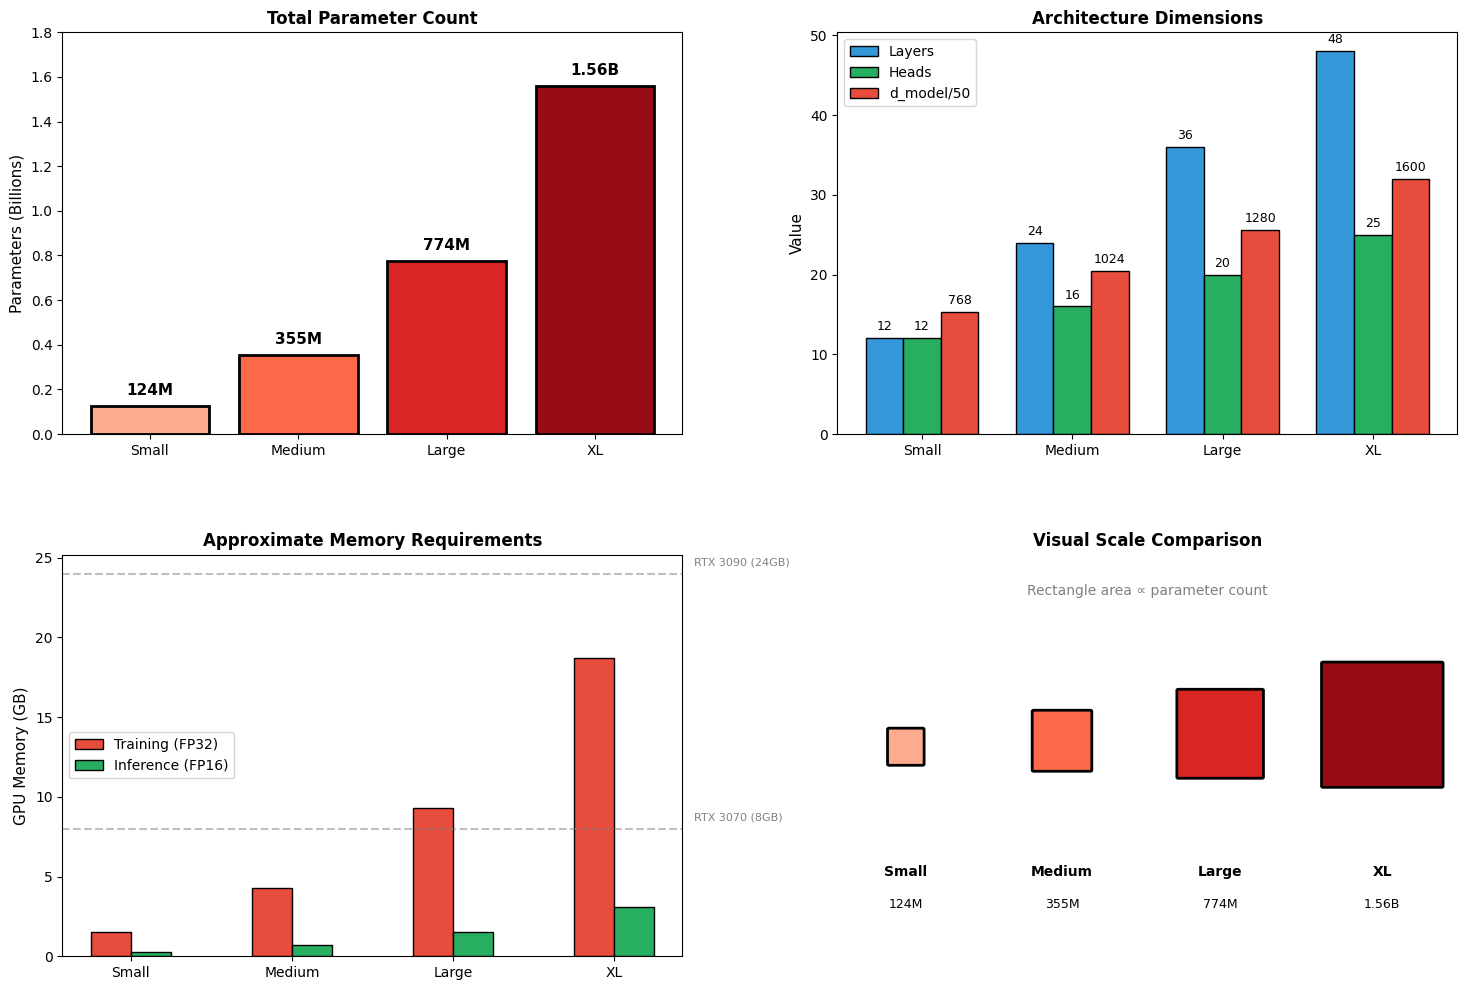

In [8]:
def visualize_model_sizes():
    """
    Comprehensive visualization of all GPT-2 model sizes.
    """
    fig = plt.figure(figsize=(18, 12))

    gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.25)

    models = ['Small', 'Medium', 'Large', 'XL']
    params = [124439808, 354823168, 774030080, 1557611200]  # Calculated
    layers = [12, 24, 36, 48]
    dims = [768, 1024, 1280, 1600]
    heads = [12, 16, 20, 25]
    colors = plt.cm.Reds(np.linspace(0.3, 0.9, 4))

    # === TOP LEFT: Parameter Count ===
    ax1 = fig.add_subplot(gs[0, 0])
    bars = ax1.bar(models, [p/1e9 for p in params], color=colors, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Parameters (Billions)', fontsize=11)
    ax1.set_title('Total Parameter Count', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, 1.8)

    for bar, p in zip(bars, params):
        label = f'{p/1e6:.0f}M' if p < 1e9 else f'{p/1e9:.2f}B'
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                label, ha='center', fontsize=11, fontweight='bold')

    # === TOP RIGHT: Architecture Dimensions ===
    ax2 = fig.add_subplot(gs[0, 1])

    x = np.arange(len(models))
    width = 0.25

    ax2.bar(x - width, layers, width, label='Layers', color='#3498db', edgecolor='black')
    ax2.bar(x, heads, width, label='Heads', color='#27ae60', edgecolor='black')
    ax2.bar(x + width, [d/50 for d in dims], width, label='d_model/50', color='#e74c3c', edgecolor='black')

    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.set_ylabel('Value', fontsize=11)
    ax2.set_title('Architecture Dimensions', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)

    # Add actual values
    for i, (l, h, d) in enumerate(zip(layers, heads, dims)):
        ax2.text(i-width, l+1, str(l), ha='center', fontsize=9)
        ax2.text(i, h+1, str(h), ha='center', fontsize=9)
        ax2.text(i+width, d/50+1, str(d), ha='center', fontsize=9)

    # === BOTTOM LEFT: Memory Requirements ===
    ax3 = fig.add_subplot(gs[1, 0])

    # Approximate memory (params × 4 bytes × 2 for gradients + activations)
    memory_train = [p * 4 * 3 / 1e9 for p in params]  # Training (fp32, grads, optimizer)
    memory_infer = [p * 2 / 1e9 for p in params]  # Inference (fp16)

    ax3.bar(x - width/2, memory_train, width, label='Training (FP32)', color='#e74c3c', edgecolor='black')
    ax3.bar(x + width/2, memory_infer, width, label='Inference (FP16)', color='#27ae60', edgecolor='black')

    ax3.set_xticks(x)
    ax3.set_xticklabels(models)
    ax3.set_ylabel('GPU Memory (GB)', fontsize=11)
    ax3.set_title('Approximate Memory Requirements', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)

    # Reference lines for common GPUs
    ax3.axhline(y=8, color='gray', linestyle='--', alpha=0.5)
    ax3.text(3.5, 8.5, 'RTX 3070 (8GB)', fontsize=8, color='gray')
    ax3.axhline(y=24, color='gray', linestyle='--', alpha=0.5)
    ax3.text(3.5, 24.5, 'RTX 3090 (24GB)', fontsize=8, color='gray')

    # === BOTTOM RIGHT: Scaling Visualization ===
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_xlim(0, 12)
    ax4.set_ylim(0, 10)
    ax4.axis('off')
    ax4.set_title('Visual Scale Comparison', fontsize=12, fontweight='bold')

    # Draw scaled rectangles
    max_area = 1.5  # XL = 1.5B

    for i, (name, p, color) in enumerate(zip(models, params, colors)):
        x_pos = 1 + i * 2.8
        # Size proportional to sqrt of parameters
        size = 1.5 * np.sqrt(p / 1e9 / max_area)

        rect = FancyBboxPatch((x_pos, 5-size/2), size*1.5, size*2, boxstyle="round,pad=0.03",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax4.add_patch(rect)

        ax4.text(x_pos + size*0.75, 2, name, ha='center', fontsize=10, fontweight='bold')
        label = f'{p/1e6:.0f}M' if p < 1e9 else f'{p/1e9:.2f}B'
        ax4.text(x_pos + size*0.75, 1.2, label, ha='center', fontsize=9)

    ax4.text(6, 9, 'Rectangle area ∝ parameter count', ha='center', fontsize=10, color='gray')

    plt.tight_layout()
    plt.show()

visualize_model_sizes()

---

## 5. Complete Implementation

Now let's implement the full GPT-2 architecture with all modifications.

In [9]:
def gelu(x: torch.Tensor) -> torch.Tensor:
    """
    Gaussian Error Linear Unit activation.

    GPT-2 uses the same GELU as GPT-1, with the tanh approximation:
    GELU(x) ≈ 0.5 * x * (1 + tanh(sqrt(2/π) * (x + 0.044715 * x³)))

    Args:
        x: Input tensor of any shape

    Returns:
        Tensor with GELU applied element-wise
    """
    return 0.5 * x * (1.0 + torch.tanh(
        math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3))
    ))


class LayerNorm(nn.Module):
    """
    Layer Normalization with optional bias.

    Normalizes across the last dimension (features).

    Args:
        n_embd: Feature dimension
        bias: Whether to include bias term
        eps: Small constant for numerical stability
    """

    def __init__(self, n_embd: int, bias: bool = True, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(n_embd))
        self.bias = nn.Parameter(torch.zeros(n_embd)) if bias else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Apply layer normalization."""
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)

        out = self.weight * x_norm
        if self.bias is not None:
            out = out + self.bias
        return out


class CausalSelfAttention(nn.Module):
    """
    Multi-Head Causal Self-Attention.

    Implements the attention mechanism with:
    - Combined Q/K/V projection for efficiency
    - Causal masking (can't attend to future)
    - Multi-head attention with head_dim = n_embd // n_head

    The c_proj layer is initialized with scaled std for residual connections.

    Args:
        config: GPT2Config with model hyperparameters
    """

    def __init__(self, config: GPT2Config):
        super().__init__()

        assert config.n_embd % config.n_head == 0, \
            f"n_embd ({config.n_embd}) must be divisible by n_head ({config.n_head})"

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = config.head_dim
        self.scale = 1.0 / math.sqrt(self.head_dim)

        # Combined Q, K, V projection: n_embd → 3 * n_embd
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)

        # Output projection: n_embd → n_embd
        # NOTE: This layer gets scaled initialization!
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)

        # Dropout
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

        # Causal mask: lower triangular
        mask = torch.tril(torch.ones(config.n_positions, config.n_positions))
        self.register_buffer('mask', mask.view(1, 1, config.n_positions, config.n_positions))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            x: Input tensor, shape (batch, seq_len, n_embd)

        Returns:
            Output tensor, shape (batch, seq_len, n_embd)
        """
        B, T, C = x.shape

        # Combined Q, K, V projection
        qkv = self.c_attn(x)  # (B, T, 3*C)
        q, k, v = qkv.split(self.n_embd, dim=2)  # Each: (B, T, C)

        # Reshape for multi-head attention
        # (B, T, C) → (B, T, n_head, head_dim) → (B, n_head, T, head_dim)
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        # Attention scores: (B, n_head, T, T)
        attn = (q @ k.transpose(-2, -1)) * self.scale

        # Apply causal mask
        attn = attn.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        # Softmax and dropout
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)

        # Apply attention to values: (B, n_head, T, head_dim)
        out = attn @ v

        # Concatenate heads: (B, T, C)
        out = out.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection and dropout
        out = self.resid_dropout(self.c_proj(out))

        return out


class MLP(nn.Module):
    """
    Position-wise Feed-Forward Network.

    Two linear layers with GELU activation:
    - c_fc: n_embd → n_inner (4 * n_embd)
    - c_proj: n_inner → n_embd

    The c_proj layer gets scaled initialization for residual connections.

    Args:
        config: GPT2Config with model hyperparameters
    """

    def __init__(self, config: GPT2Config):
        super().__init__()

        # Expand: n_embd → 4 * n_embd
        self.c_fc = nn.Linear(config.n_embd, config.n_inner)

        # Contract: 4 * n_embd → n_embd
        # NOTE: This layer gets scaled initialization!
        self.c_proj = nn.Linear(config.n_inner, config.n_embd)

        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            x: Input tensor, shape (batch, seq_len, n_embd)

        Returns:
            Output tensor, shape (batch, seq_len, n_embd)
        """
        x = self.c_fc(x)
        x = gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    GPT-2 Transformer Block with PRE-LAYERNORM.

    This is THE KEY DIFFERENCE from GPT-1:

    GPT-1 (Post-LN):  x = LayerNorm(x + Sublayer(x))
    GPT-2 (Pre-LN):   x = x + Sublayer(LayerNorm(x))

    Pre-LN provides:
    - Better gradient flow (direct residual path)
    - More stable training at depth
    - No need for careful warmup

    Args:
        config: GPT2Config with model hyperparameters
    """

    def __init__(self, config: GPT2Config):
        super().__init__()

        # Pre-LayerNorm for attention
        self.ln_1 = LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)

        # Pre-LayerNorm for MLP
        self.ln_2 = LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with Pre-LN.

        Args:
            x: Input tensor, shape (batch, seq_len, n_embd)

        Returns:
            Output tensor, shape (batch, seq_len, n_embd)
        """
        # Pre-LN Attention: x = x + Attn(LN(x))
        x = x + self.attn(self.ln_1(x))

        # Pre-LN MLP: x = x + MLP(LN(x))
        x = x + self.mlp(self.ln_2(x))

        return x


print("GPT-2 components defined!")

GPT-2 components defined!


In [10]:
class GPT2(nn.Module):
    """
    Complete GPT-2 Language Model.

    Key differences from GPT-1:
    1. Pre-LayerNorm (LN before sublayers, not after)
    2. Additional final LayerNorm after all blocks
    3. Scaled initialization for residual layers (1/√N)
    4. Larger context (1024 vs 512)
    5. Byte-level BPE vocabulary (50,257 tokens)

    Architecture:
        Input IDs → Token Embedding + Position Embedding → Dropout
        → N × Transformer Blocks (Pre-LN)
        → Final LayerNorm → LM Head → Logits

    Args:
        config: GPT2Config with model hyperparameters
    """

    def __init__(self, config: GPT2Config):
        super().__init__()
        self.config = config

        # ============================================================
        # EMBEDDINGS
        # ============================================================

        # Token embeddings: vocab_size → n_embd
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)

        # Position embeddings: n_positions → n_embd (LEARNED, not sinusoidal)
        self.wpe = nn.Embedding(config.n_positions, config.n_embd)

        # Embedding dropout
        self.drop = nn.Dropout(config.embd_pdrop)

        # ============================================================
        # TRANSFORMER BLOCKS
        # ============================================================

        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])

        # ============================================================
        # OUTPUT
        # ============================================================

        # Final LayerNorm (GPT-2 specific!)
        # Paper: "an additional layer normalization was added after the final self-attention block"
        self.ln_f = LayerNorm(config.n_embd)

        # Language model head (tied with token embeddings)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight tying: share weights between token embedding and LM head
        self.lm_head.weight = self.wte.weight

        # ============================================================
        # INITIALIZATION
        # ============================================================

        # Standard initialization
        self.apply(self._init_weights)

        # CRITICAL: Scaled initialization for residual layers
        # Paper: "scale the weights of residual layers at initialization by 1/√N"
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                # Scale by 1/√(2*n_layer) for residual projections
                torch.nn.init.normal_(p, mean=0.0, std=config.residual_std)

        # Report
        n_params = sum(p.numel() for p in self.parameters())
        print(f"GPT-2 ({config.n_layer} layers, {config.n_embd} dim): {n_params:,} parameters")

    def _init_weights(self, module: nn.Module):
        """
        Standard weight initialization: N(0, 0.02).

        This is applied first, then residual layers are re-initialized with scaling.
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(
        self,
        input_ids: torch.Tensor,
        targets: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Forward pass.

        Args:
            input_ids: Token IDs, shape (batch, seq_len)
            targets: Target token IDs for loss, shape (batch, seq_len)

        Returns:
            logits: Vocabulary logits, shape (batch, seq_len, vocab_size)
            loss: Cross-entropy loss if targets provided
        """
        B, T = input_ids.shape

        assert T <= self.config.n_positions, \
            f"Sequence length {T} exceeds max {self.config.n_positions}"

        # Get embeddings
        tok_emb = self.wte(input_ids)  # (B, T, n_embd)
        pos = torch.arange(T, device=input_ids.device)  # (T,)
        pos_emb = self.wpe(pos)  # (T, n_embd)

        # Combine and apply dropout
        x = self.drop(tok_emb + pos_emb)  # (B, T, n_embd)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)

        # Final LayerNorm (GPT-2 specific)
        x = self.ln_f(x)

        # Project to vocabulary
        logits = self.lm_head(x)  # (B, T, vocab_size)

        # Compute loss if targets provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1)
            )

        return logits, loss


# Create and test GPT-2 Small
print("\nCreating GPT-2 Small:")
model_small = GPT2(GPT2_SMALL)

print("\nCreating GPT-2 Medium:")
model_medium = GPT2(GPT2_MEDIUM)


Creating GPT-2 Small:
GPT-2 (12 layers, 768 dim): 124,439,808 parameters

Creating GPT-2 Medium:
GPT-2 (24 layers, 1024 dim): 354,823,168 parameters


In [11]:
def test_model(model: GPT2, name: str):
    """Test a GPT-2 model."""
    print(f"\n{'='*60}")
    print(f"Testing {name}")
    print(f"{'='*60}")

    config = model.config

    # Test forward pass
    batch_size = 2
    seq_len = 64

    x = torch.randint(0, config.vocab_size, (batch_size, seq_len))
    targets = torch.randint(0, config.vocab_size, (batch_size, seq_len))

    model.eval()
    with torch.no_grad():
        logits, loss = model(x, targets)

    print(f"\nInput shape:    {x.shape}")
    print(f"Logits shape:   {logits.shape}")
    print(f"Loss:           {loss.item():.4f}")
    print(f"Expected loss:  {math.log(config.vocab_size):.4f} (random baseline)")

    # Verify initialization scaling
    print(f"\nInitialization verification:")
    print(f"  Expected residual std: {config.residual_std:.6f}")

    # Check actual std of c_proj weights
    c_proj_stds = []
    for name_p, p in model.named_parameters():
        if 'c_proj.weight' in name_p:
            c_proj_stds.append(p.std().item())

    print(f"  Actual c_proj std:     {np.mean(c_proj_stds):.6f} (mean of {len(c_proj_stds)} layers)")

    # Memory estimate
    n_params = sum(p.numel() for p in model.parameters())
    memory_mb = n_params * 4 / 1e6  # FP32
    print(f"\nMemory (FP32): {memory_mb:.1f} MB")

test_model(model_small, "GPT-2 Small")
test_model(model_medium, "GPT-2 Medium")


Testing GPT-2 Small

Input shape:    torch.Size([2, 64])
Logits shape:   torch.Size([2, 64, 50257])
Loss:           10.9128
Expected loss:  10.8249 (random baseline)

Initialization verification:
  Expected residual std: 0.004082
  Actual c_proj std:     0.004082 (mean of 24 layers)

Memory (FP32): 497.8 MB

Testing GPT-2 Medium

Input shape:    torch.Size([2, 64])
Logits shape:   torch.Size([2, 64, 50257])
Loss:           11.0612
Expected loss:  10.8249 (random baseline)

Initialization verification:
  Expected residual std: 0.002887
  Actual c_proj std:     0.002887 (mean of 48 layers)

Memory (FP32): 1419.3 MB


---

## 6. Summary: The Complete Architecture Picture

### 6.1 All Changes in One Place

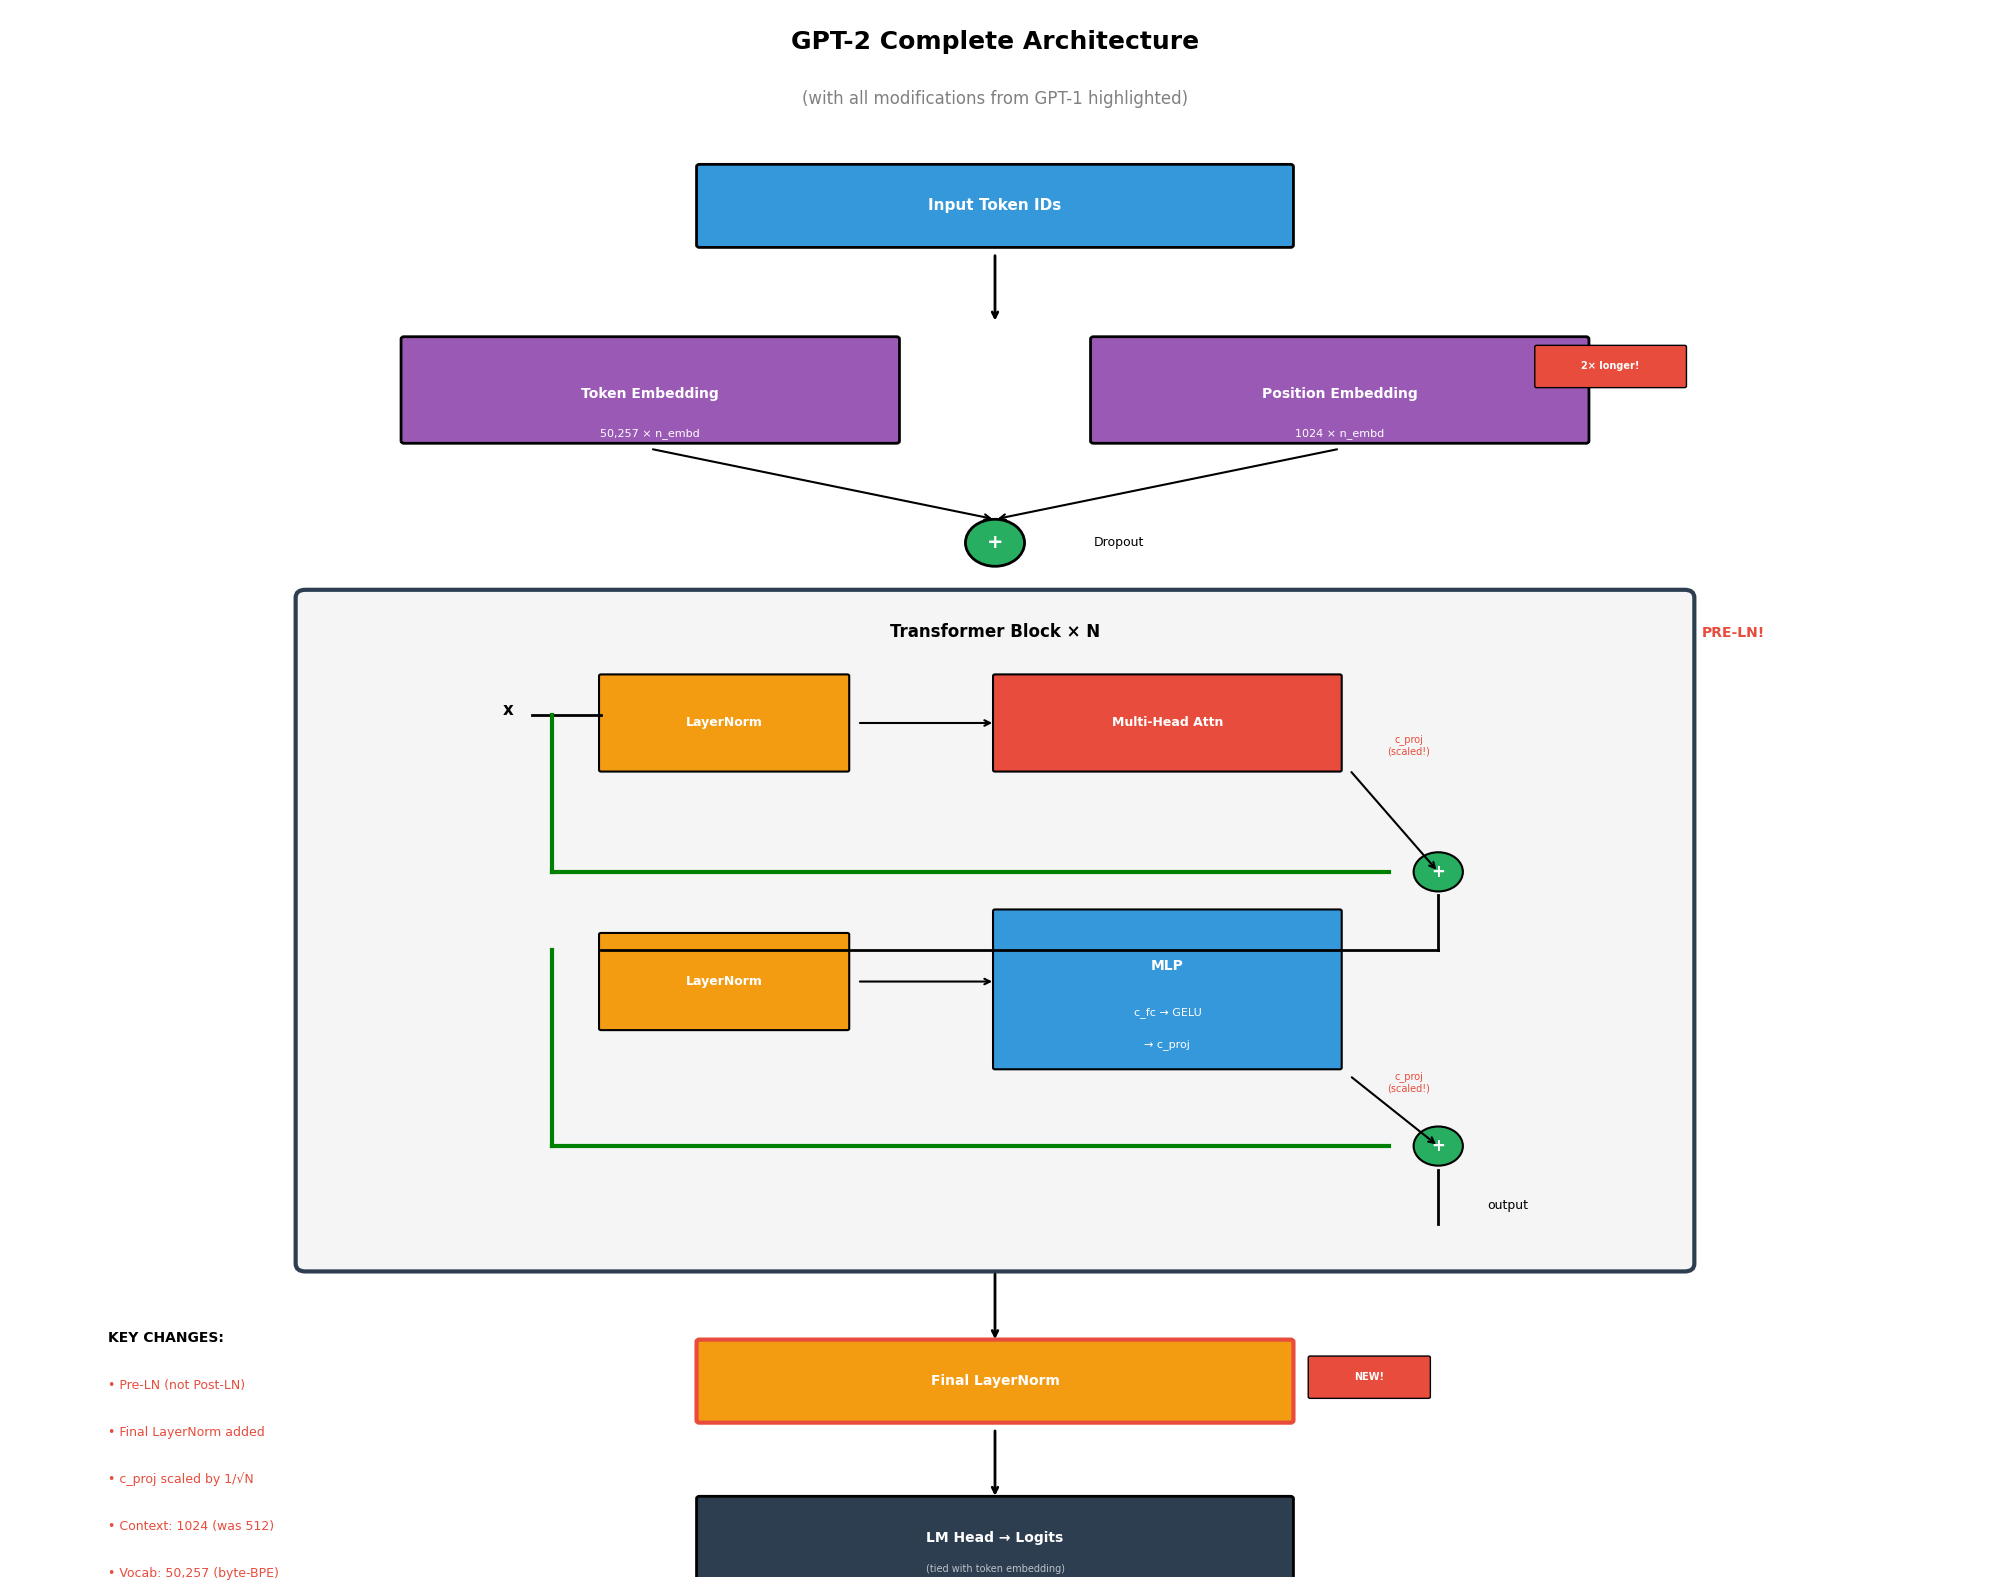

In [12]:
def visualize_complete_architecture():
    """
    Complete GPT-2 architecture diagram.
    """
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_subplot(111)
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    ax.axis('off')

    ax.text(10, 19.5, 'GPT-2 Complete Architecture', fontsize=18, fontweight='bold', ha='center')
    ax.text(10, 18.8, '(with all modifications from GPT-1 highlighted)', fontsize=12, ha='center', color='gray')

    # === INPUT ===
    rect = FancyBboxPatch((7, 17), 6, 1, boxstyle="round,pad=0.03",
                          facecolor='#3498db', edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(10, 17.5, 'Input Token IDs', ha='center', va='center', fontsize=11, color='white', fontweight='bold')

    ax.annotate('', xy=(10, 16), xytext=(10, 16.9),
               arrowprops=dict(arrowstyle='->', color='black', lw=2))

    # === EMBEDDINGS ===
    rect = FancyBboxPatch((4, 14.5), 5, 1.3, boxstyle="round,pad=0.03",
                          facecolor='#9b59b6', edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(6.5, 15.1, 'Token Embedding', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    ax.text(6.5, 14.6, '50,257 × n_embd', ha='center', va='center', fontsize=8, color='white')

    rect = FancyBboxPatch((11, 14.5), 5, 1.3, boxstyle="round,pad=0.03",
                          facecolor='#9b59b6', edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(13.5, 15.1, 'Position Embedding', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    ax.text(13.5, 14.6, '1024 × n_embd', ha='center', va='center', fontsize=8, color='white')

    # NEW badge
    rect_new = FancyBboxPatch((15.5, 15.2), 1.5, 0.5, boxstyle="round,pad=0.02",
                               facecolor='#e74c3c', edgecolor='black', linewidth=1)
    ax.add_patch(rect_new)
    ax.text(16.25, 15.45, '2× longer!', ha='center', va='center', fontsize=7, color='white', fontweight='bold')

    # Add + Dropout
    ax.annotate('', xy=(10, 13.5), xytext=(6.5, 14.4),
               arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    ax.annotate('', xy=(10, 13.5), xytext=(13.5, 14.4),
               arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    circle = plt.Circle((10, 13.2), 0.3, facecolor='#27ae60', edgecolor='black', linewidth=2)
    ax.add_patch(circle)
    ax.text(10, 13.2, '+', ha='center', va='center', fontsize=14, color='white', fontweight='bold')
    ax.text(11, 13.2, 'Dropout', fontsize=9, va='center')

    # === TRANSFORMER BLOCK (detailed) ===
    block_rect = FancyBboxPatch((3, 4), 14, 8.5, boxstyle="round,pad=0.1",
                                 facecolor='#f5f5f5', edgecolor='#2c3e50', linewidth=3)
    ax.add_patch(block_rect)
    ax.text(10, 12, 'Transformer Block × N', ha='center', fontsize=12, fontweight='bold')
    ax.text(17.5, 12, 'PRE-LN!', ha='center', fontsize=10, fontweight='bold', color='#e74c3c')

    # Input to block
    ax.text(5, 11, 'x', fontsize=12, fontweight='bold')
    ax.plot([5.3, 6], [11, 11], 'k-', linewidth=2)

    # LayerNorm 1 (PRE!)
    rect = FancyBboxPatch((6, 10.3), 2.5, 1.2, boxstyle="round,pad=0.02",
                          facecolor='#f39c12', edgecolor='black', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(7.25, 10.9, 'LayerNorm', ha='center', va='center', fontsize=9, color='white', fontweight='bold')

    # Attention
    ax.annotate('', xy=(10, 10.9), xytext=(8.6, 10.9),
               arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    rect = FancyBboxPatch((10, 10.3), 3.5, 1.2, boxstyle="round,pad=0.02",
                          facecolor='#e74c3c', edgecolor='black', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(11.75, 10.9, 'Multi-Head Attn', ha='center', va='center', fontsize=9, color='white', fontweight='bold')

    # Residual add (attention)
    ax.plot([5.5, 5.5], [11, 9], 'g-', linewidth=3)  # Residual path
    ax.plot([5.5, 14], [9, 9], 'g-', linewidth=3)

    ax.annotate('', xy=(14.5, 9), xytext=(13.6, 10.3),
               arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    circle = plt.Circle((14.5, 9), 0.25, facecolor='#27ae60', edgecolor='black', linewidth=1.5)
    ax.add_patch(circle)
    ax.text(14.5, 9, '+', ha='center', va='center', fontsize=12, color='white', fontweight='bold')

    # c_proj annotation
    ax.text(14.2, 10.5, 'c_proj\n(scaled!)', fontsize=7, color='#e74c3c', ha='center')

    # LayerNorm 2 (PRE!)
    ax.plot([14.5, 14.5], [8.7, 8], 'k-', linewidth=2)
    ax.plot([14.5, 6], [8, 8], 'k-', linewidth=2)

    rect = FancyBboxPatch((6, 7), 2.5, 1.2, boxstyle="round,pad=0.02",
                          facecolor='#f39c12', edgecolor='black', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(7.25, 7.6, 'LayerNorm', ha='center', va='center', fontsize=9, color='white', fontweight='bold')

    # MLP
    ax.annotate('', xy=(10, 7.6), xytext=(8.6, 7.6),
               arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    rect = FancyBboxPatch((10, 6.5), 3.5, 2, boxstyle="round,pad=0.02",
                          facecolor='#3498db', edgecolor='black', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(11.75, 7.8, 'MLP', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    ax.text(11.75, 7.2, 'c_fc → GELU', ha='center', va='center', fontsize=8, color='white')
    ax.text(11.75, 6.8, '→ c_proj', ha='center', va='center', fontsize=8, color='white')

    # Residual add (MLP)
    ax.plot([5.5, 5.5], [8, 5.5], 'g-', linewidth=3)
    ax.plot([5.5, 14], [5.5, 5.5], 'g-', linewidth=3)

    ax.annotate('', xy=(14.5, 5.5), xytext=(13.6, 6.4),
               arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    circle = plt.Circle((14.5, 5.5), 0.25, facecolor='#27ae60', edgecolor='black', linewidth=1.5)
    ax.add_patch(circle)
    ax.text(14.5, 5.5, '+', ha='center', va='center', fontsize=12, color='white', fontweight='bold')

    # c_proj annotation
    ax.text(14.2, 6.2, 'c_proj\n(scaled!)', fontsize=7, color='#e74c3c', ha='center')

    # Output of block
    ax.plot([14.5, 14.5], [5.2, 4.5], 'k-', linewidth=2)
    ax.text(15, 4.7, 'output', fontsize=9)

    # === FINAL LAYER NORM (NEW!) ===
    ax.annotate('', xy=(10, 3), xytext=(10, 3.9),
               arrowprops=dict(arrowstyle='->', color='black', lw=2))

    rect = FancyBboxPatch((7, 2), 6, 1, boxstyle="round,pad=0.03",
                          facecolor='#f39c12', edgecolor='#e74c3c', linewidth=3)
    ax.add_patch(rect)
    ax.text(10, 2.5, 'Final LayerNorm', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    rect_new = FancyBboxPatch((13.2, 2.3), 1.2, 0.5, boxstyle="round,pad=0.02",
                               facecolor='#e74c3c', edgecolor='black', linewidth=1)
    ax.add_patch(rect_new)
    ax.text(13.8, 2.55, 'NEW!', ha='center', va='center', fontsize=7, color='white', fontweight='bold')

    # === LM HEAD ===
    ax.annotate('', xy=(10, 1), xytext=(10, 1.9),
               arrowprops=dict(arrowstyle='->', color='black', lw=2))

    rect = FancyBboxPatch((7, 0), 6, 1, boxstyle="round,pad=0.03",
                          facecolor='#2c3e50', edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(10, 0.5, 'LM Head → Logits', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    ax.text(10, 0.1, '(tied with token embedding)', ha='center', va='center', fontsize=7, color='#bdc3c7')

    # Legend
    ax.text(1, 3, 'KEY CHANGES:', fontsize=10, fontweight='bold')
    ax.text(1, 2.4, '• Pre-LN (not Post-LN)', fontsize=9, color='#e74c3c')
    ax.text(1, 1.8, '• Final LayerNorm added', fontsize=9, color='#e74c3c')
    ax.text(1, 1.2, '• c_proj scaled by 1/√N', fontsize=9, color='#e74c3c')
    ax.text(1, 0.6, '• Context: 1024 (was 512)', fontsize=9, color='#e74c3c')
    ax.text(1, 0, '• Vocab: 50,257 (byte-BPE)', fontsize=9, color='#e74c3c')

    plt.tight_layout()
    plt.show()

visualize_complete_architecture()

---

## Summary

### GPT-2 Architecture Changes

| Change | GPT-1 | GPT-2 | Impact |
|--------|-------|-------|--------|
| **LayerNorm** | Post-LN | Pre-LN | Stable gradients at depth |
| **Final LN** | None | Added | Stable output distribution |
| **Residual Init** | std=0.02 | std=0.02/√(2N) | Bounded variance |
| **Context** | 512 | 1024 | Longer dependencies |
| **Vocabulary** | 40,478 | 50,257 | No UNK tokens |
| **Batch** | 64 | 512 | Better gradient estimates |

### Why These Changes Matter

Without these modifications, GPT-2 XL (1.5B parameters, 48 layers) would have been **impossible to train**:

1. **Pre-LN**: Enables gradient flow through 48 layers
2. **Scaled Init**: Prevents activation explosion across 96 residual connections
3. **Final LN**: Stabilizes the output before the LM head

---

### What's Next: Part III - Zero-Shot Learning

We'll cover:
- Task prompting techniques
- Translation, summarization, QA without training
- Why zero-shot emerges with scale

---

## References

1. Radford et al. (2019). [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
2. Xiong et al. (2020). [On Layer Normalization in the Transformer Architecture](https://arxiv.org/abs/2002.04745)
3. Radford et al. (2018). [Improving Language Understanding by Generative Pre-Training](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)